In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-in-tech-survey/survey.csv


# ***Importing Libraries***

In [100]:
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

#Data Preprocessing
from sklearn import preprocessing
import scipy.stats as stats

#Train test split
from sklearn.model_selection import train_test_split

#Model Training + Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
from scipy.stats import randint
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier     
from catboost import CatBoostClassifier 
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier

#Random Search CV
from sklearn.model_selection import RandomizedSearchCV

# DATA Cleaning & Processing

**Let's explore the Data**

In [17]:
df = pd.read_csv("/kaggle/input/mental-health-in-tech-survey/survey.csv")

In [4]:
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [5]:
df.shape

(1259, 27)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [6]:
df.describe()

,Age
count,1.259000e+03
mean,7.942815e+07
std,2.818299e+09
min,-1.726000e+03
25%,2.700000e+01
50%,3.100000e+01
75%,3.600000e+01
max,1.000000e+11


In [7]:
df.duplicated().sum()

0

WE are dropping these columns bcz they are useless

In [18]:
df.drop(["state","Country","Timestamp","comments","work_interfere"],axis = 1,inplace = True)

***Separating the numerical columns from the categorical for the analysis***

In [19]:
num_df = df["Age"]
cat_df = df.drop(columns = "Age",axis = 1)

In [20]:
df["Age"].max()

99999999999

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


<Axes: >

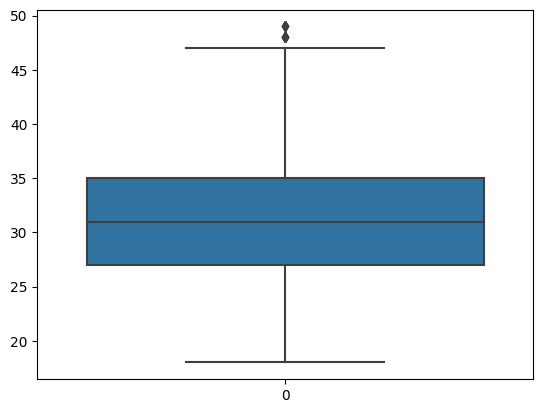

In [37]:
sns.boxplot(df["Age"])

In [21]:
#  Removing the Outliers from the Age Column

def remove_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return cleaned_df

df = remove_iqr_outliers(df, "Age")

In [9]:
df["Age"].describe()

count    1219.000000
mean       31.468417
std         6.276310
min        18.000000
25%        27.000000
50%        31.000000
75%        35.000000
max        49.000000
Name: Age, dtype: float64

In [10]:
cat_df.shape

(1259, 26)

***Pie Chart Analysis on Categorical Data***

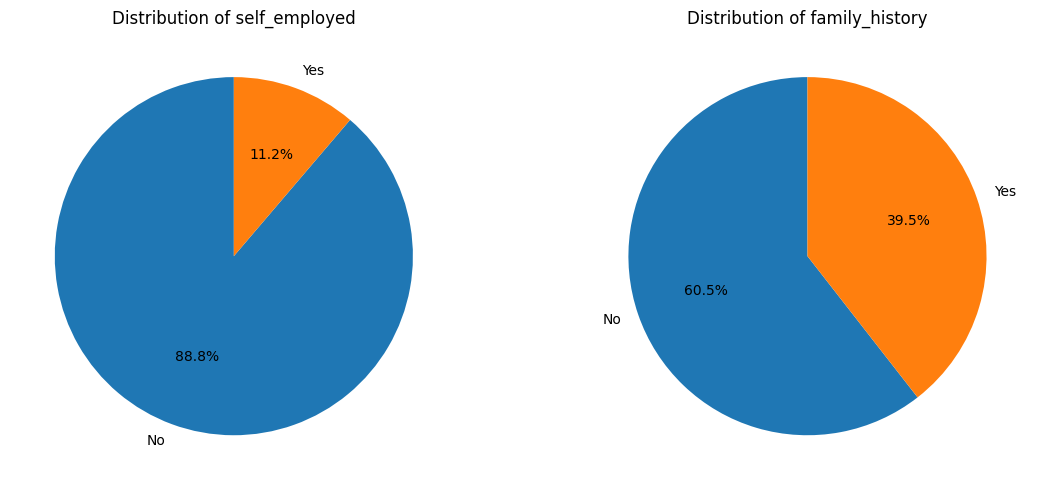

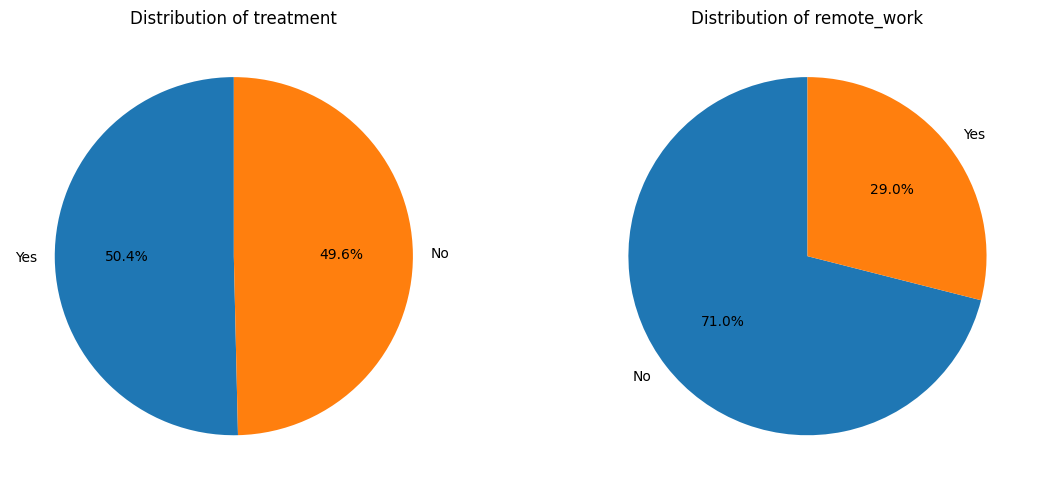

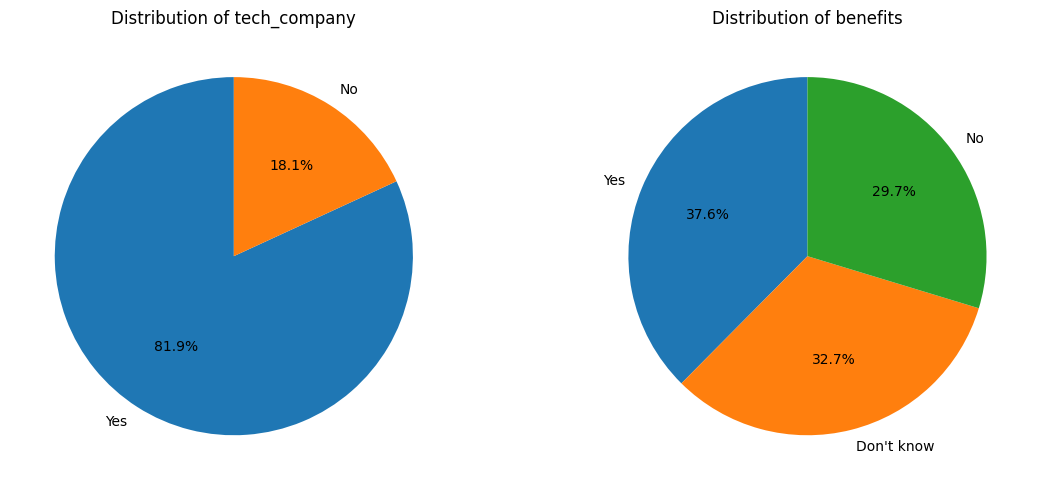

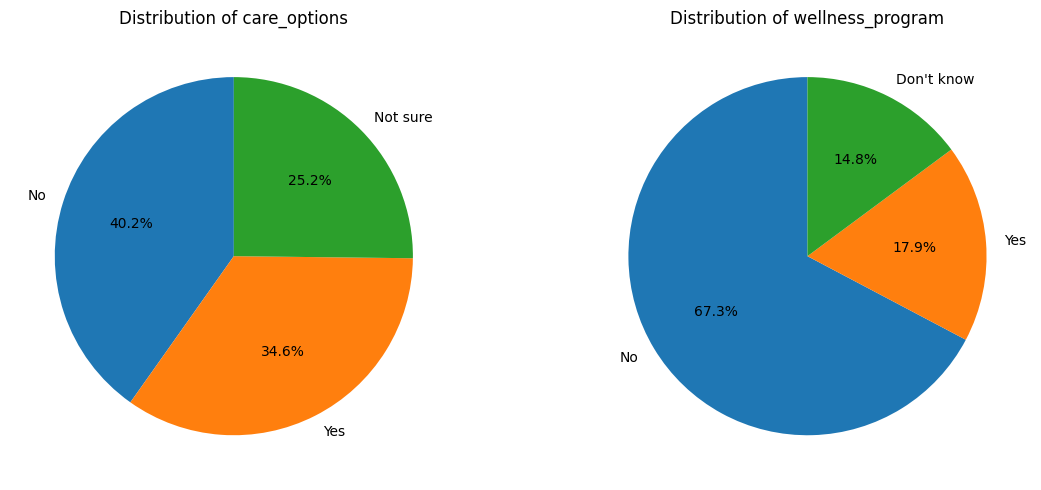

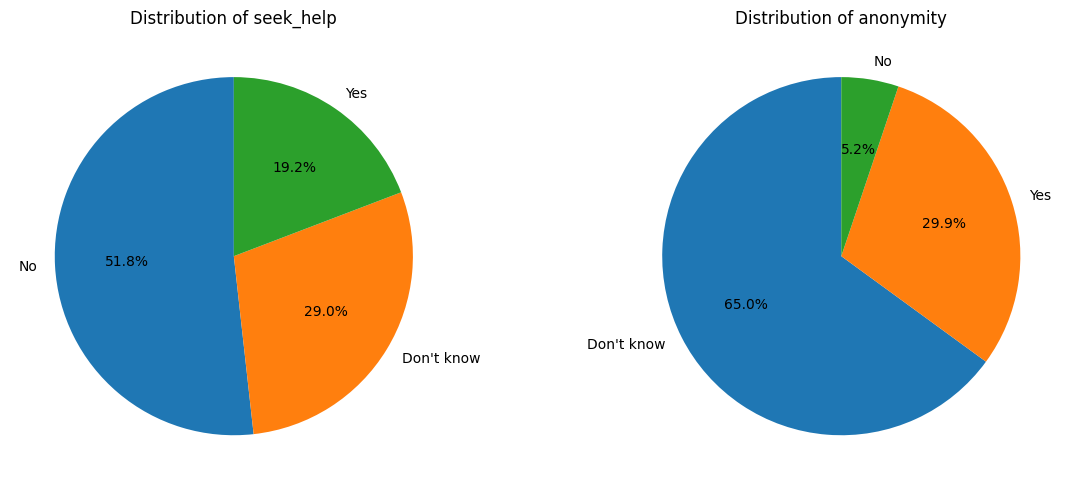

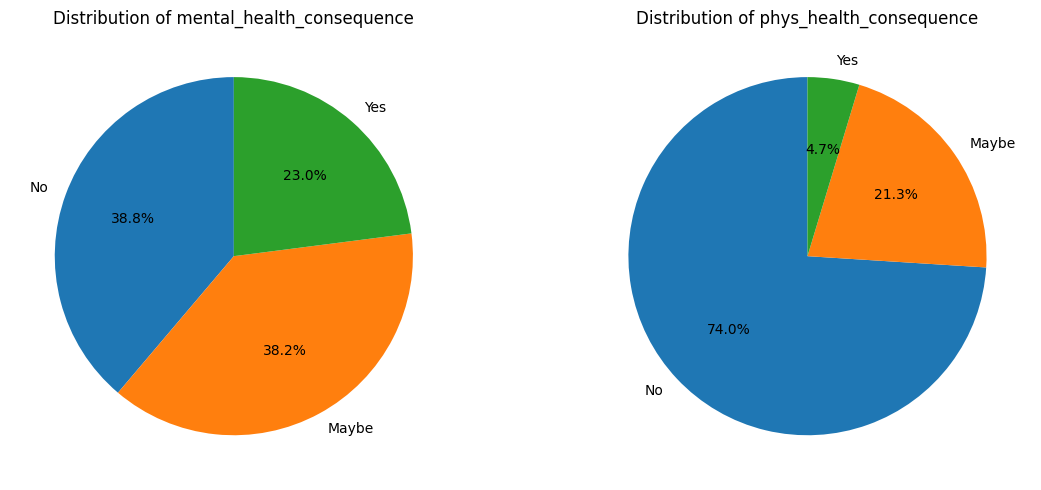

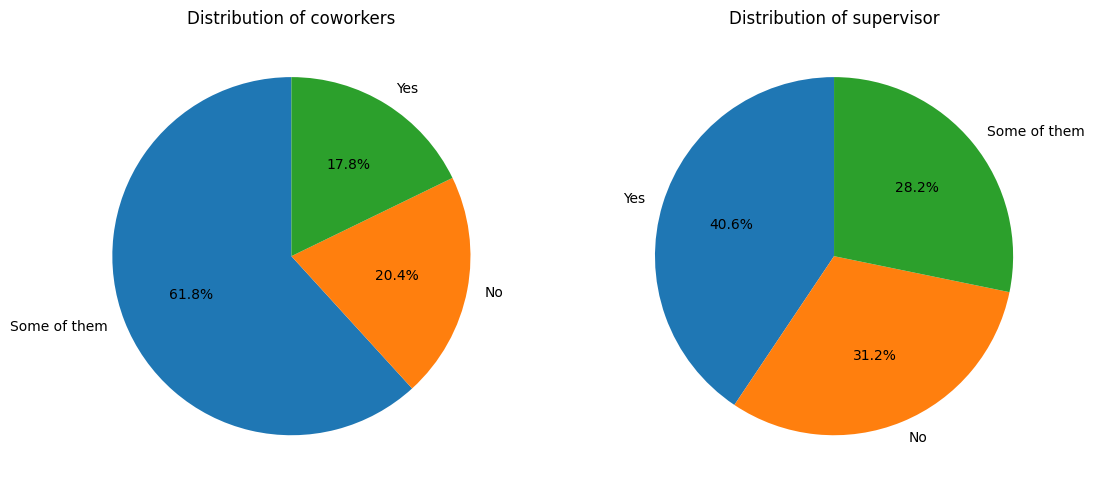

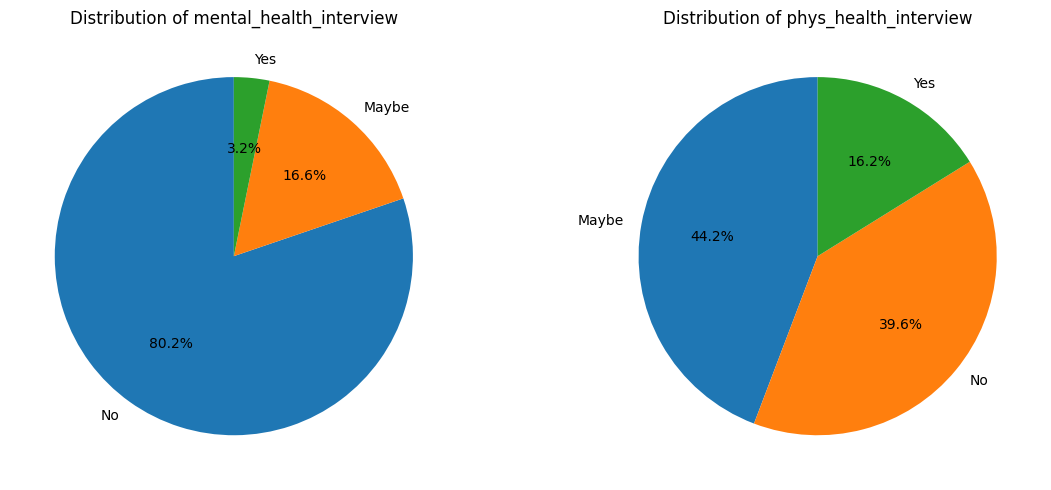

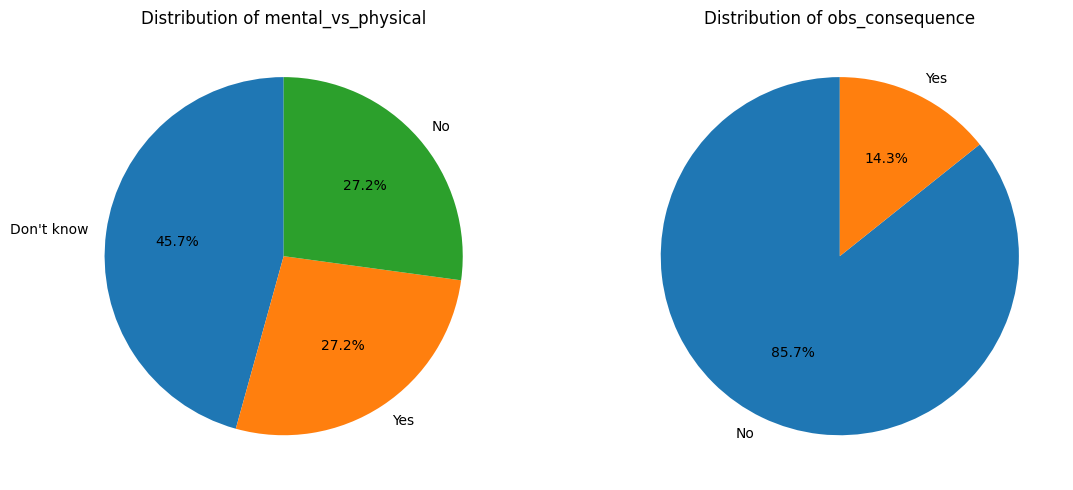

In [13]:
cols = [col for col in cat_df if df[col].nunique() < 5]

for i in range(0, len(cols), 2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for j in range(2):
        if i + j < len(cols):
            df[cols[i + j]].value_counts().plot(
                kind='pie',
                autopct='%1.1f%%',
                startangle=90,
                ax=axs[j]
            )
            axs[j].set_title(f"Distribution of {cols[i + j]}")
            axs[j].set_ylabel('')
        else:
            axs[j].axis('off')  # Hide unused subplot

    plt.tight_layout()
    plt.show()


**Take Away from these Graphs**

* Some of the graphs are equally balanced
* Some are really imbalance
* Those who are divided into three classes have more percent in one class than two classes
which leads to data imbalacing 

In [22]:
df["Gender"].unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'Enby', 'fluid',
       'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)', 'queer',
       'Female (cis)', 'Mail', 'cis male', 'Malr', 'Male ', 'femail',
       'Cis Man', 'ostensibly male, unsure what that really means'],
      dtype=object)

In [23]:
standard_genders = {
    'Male': ['male', 'm', 'male ', 'Male', 'M', 'maile', 'Mal', 'msle', 'Malr', 'Make', 'Mail', 'Cis Male', 'Male (CIS)', 'cis male', 'Man', 'Cis Man', 'Guy (-ish) ^_^'],
    'Female': ['female', 'f', 'Female', 'F', 'femail', 'Femake', 'Female ', 'Cis Female', 'cis-female/femme', 'Female (cis)', 'Woman', 'woman'],
    'Transgender': ['Trans-female', 'Trans woman', 'Female (trans)'],
    'Non-binary': ['non-binary', 'Genderqueer', 'Enby', 'fluid', 'Agender', 'Androgyne', 'queer', 'queer/she/they', 'male leaning androgynous'],
    'Other': ['something kinda male?', 'Nah', 'ostensibly male, unsure what that really means']
}
def map_gender(g):
    g = str(g).strip().lower()
    for category, keywords in standard_genders.items():
        if g in [k.lower() for k in keywords]:
            return category
    return 'Other'
df['Gender'] = df['Gender'].apply(map_gender)


In [24]:
cat_df["Gender"] = cat_df["Gender"].apply(map_gender)

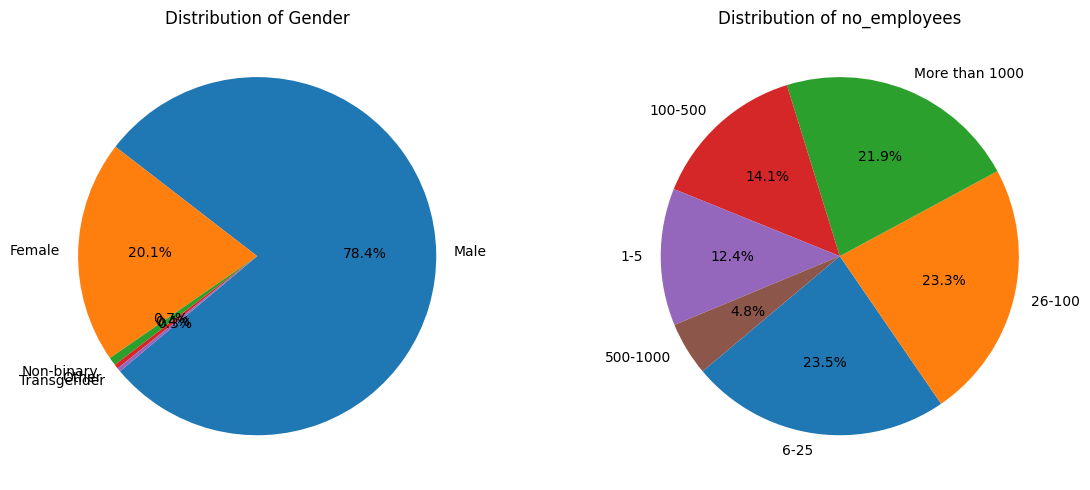

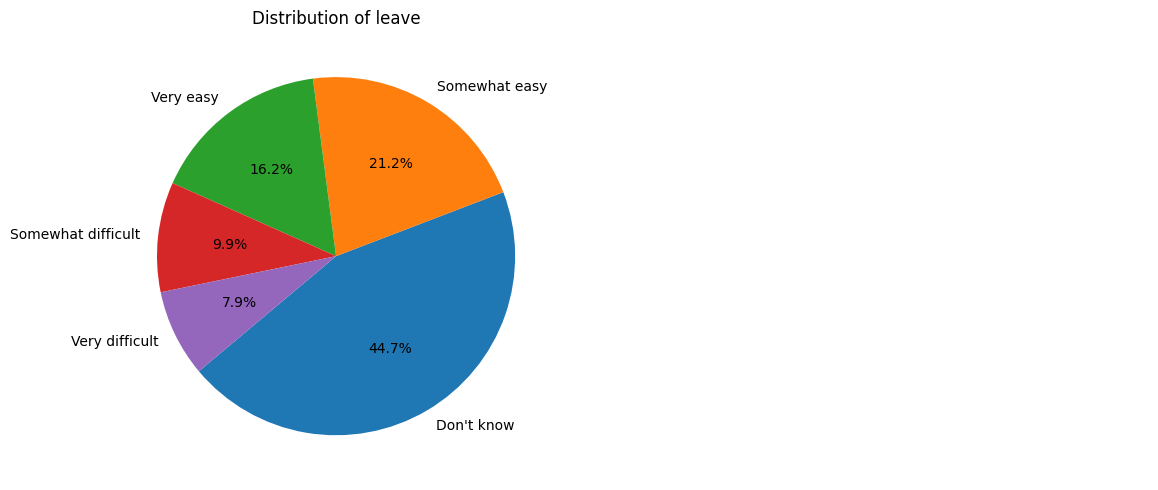

In [32]:
import matplotlib.pyplot as plt

cols = [col for col in cat_df if df[col].nunique() >= 5]

for i in range(0, len(cols), 2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for j in range(2):
        if i + j < len(cols):
            df[cols[i + j]].value_counts().plot(
                kind='pie',
                autopct='%1.1f%%',
                startangle=220,
                ax=axs[j]
            )
            axs[j].set_title(f"Distribution of {cols[i + j]}")
            axs[j].set_ylabel('')
        else:
            axs[j].axis('off')  # Hide unused subplot

    plt.tight_layout()
    plt.show()


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1219 entries, 0 to 1258
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1219 non-null   int64 
 1   Gender                     1219 non-null   object
 2   self_employed              1201 non-null   object
 3   family_history             1219 non-null   object
 4   treatment                  1219 non-null   object
 5   no_employees               1219 non-null   object
 6   remote_work                1219 non-null   object
 7   tech_company               1219 non-null   object
 8   benefits                   1219 non-null   object
 9   care_options               1219 non-null   object
 10  wellness_program           1219 non-null   object
 11  seek_help                  1219 non-null   object
 12  anonymity                  1219 non-null   object
 13  leave                      1219 non-null   object
 14  mental_health

***Bar Plot Visualization***

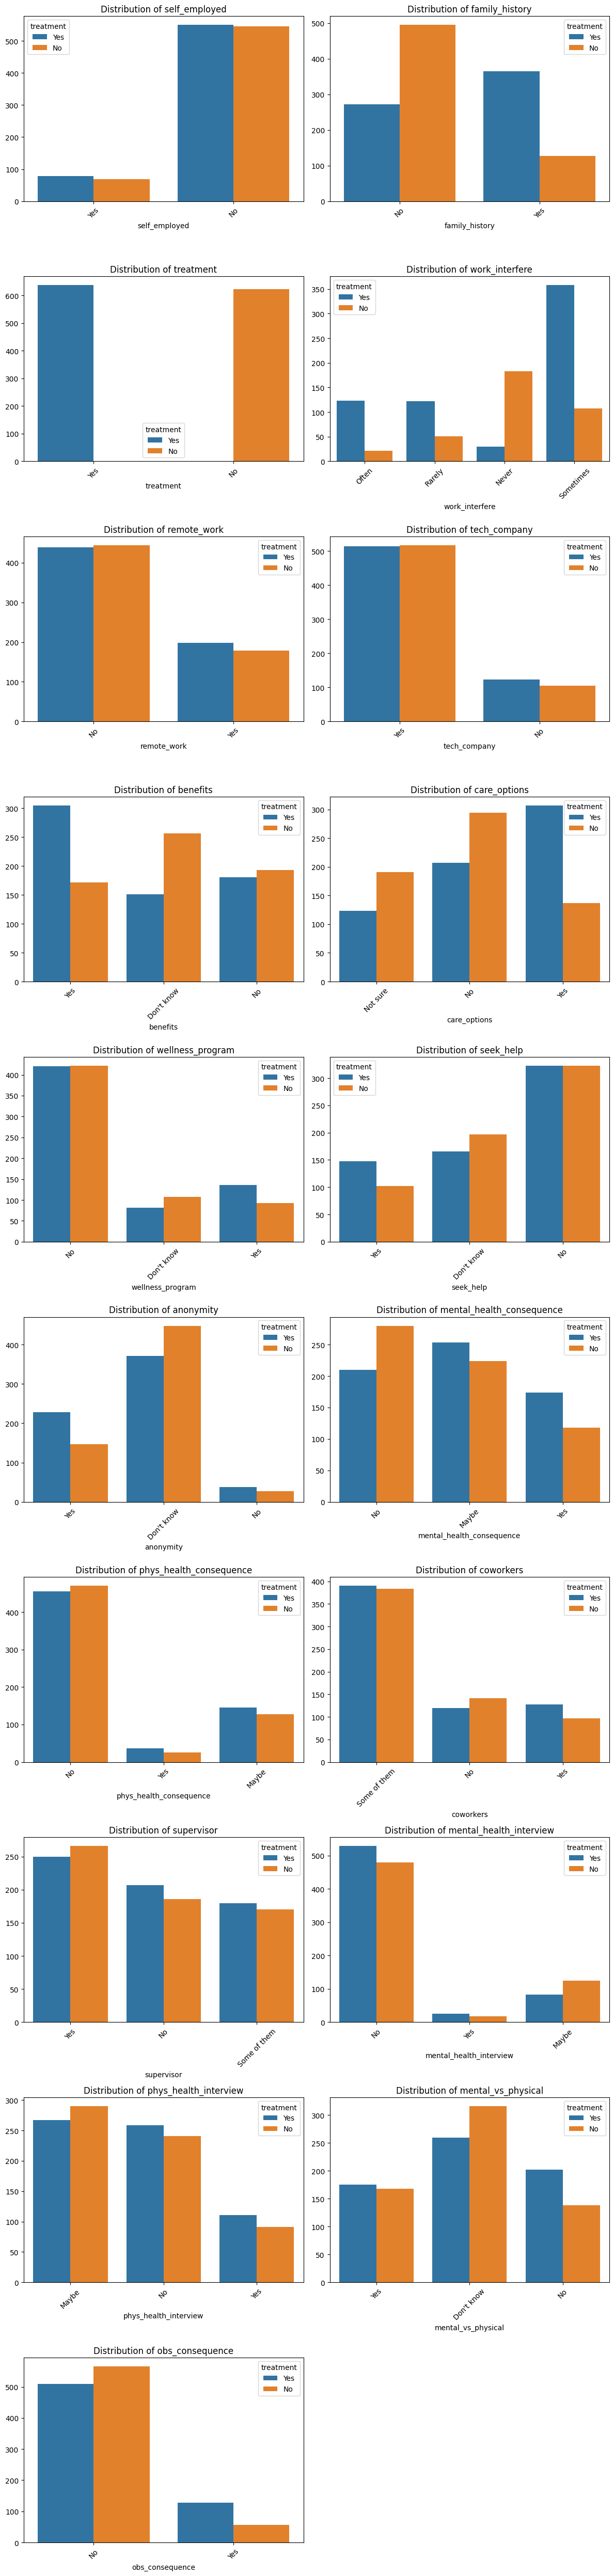

In [6]:
cat_cols = [col for col in df.select_dtypes("object").columns if df[col].nunique() < 5]

n_cols = 2
n_rows = (len(cat_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))  

axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, hue='treatment', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("") 
    axes[i].tick_params(axis='x', rotation=45)  

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


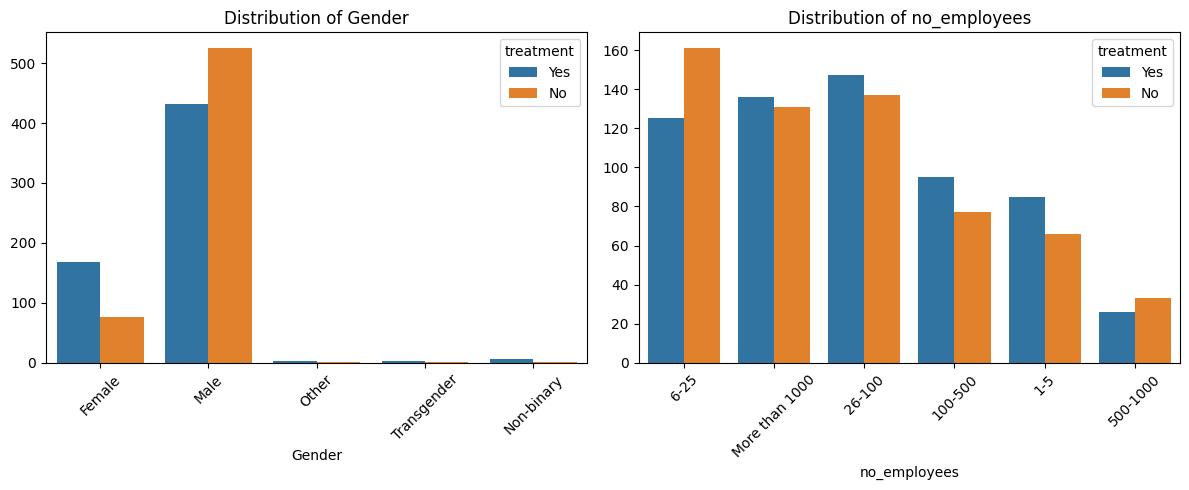

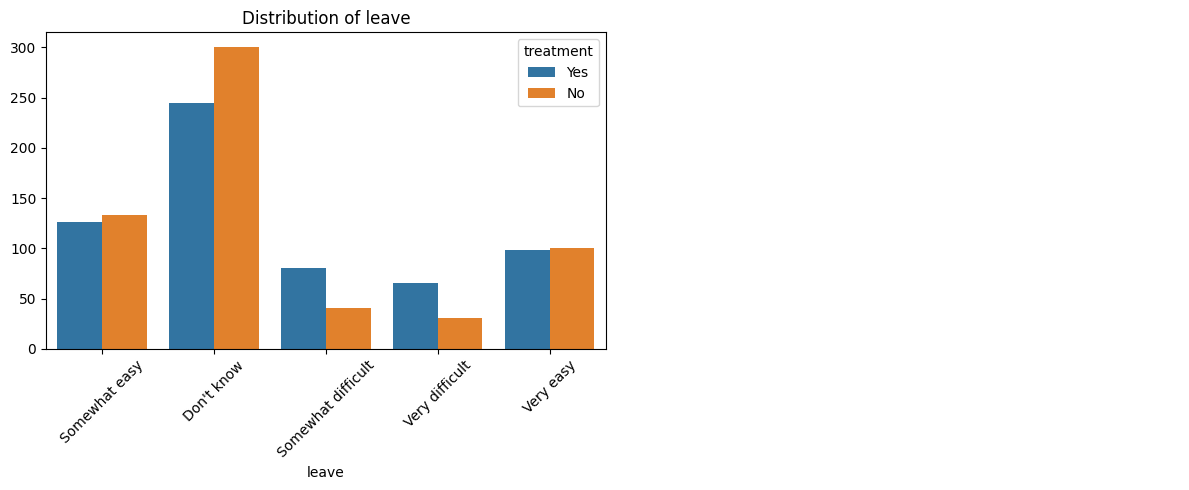

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = [col for col in df.select_dtypes("object") if df[col].nunique() >= 5]

for i in range(0, len(cols), 2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for j in range(2):
        if i + j < len(cols):
            sns.countplot(data=df, x=cols[i + j], hue='treatment', ax=axs[j])
            axs[j].set_title(f"Distribution of {cols[i + j]}")
            axs[j].set_ylabel('')
            axs[j].tick_params(axis='x', rotation=45)
        else:
            axs[j].axis('off')  # Hide unused subplot

    plt.tight_layout()
    plt.show()


**Take Away (bar plot visualizatoin w.r.t Treatment**

* The main issue in this visualization is that in most of the columns if that value is No, the Treatment has equal or more distribution for YES rather than No. which may cause the bad learning of the model while training.

So we actually has to check whether these graphs actaully has any affect on the treatment which is our Label, while on training. For that, we will use Cramers Algorithm to calculate the weightage.

In [38]:
def cramers_v(x, y):
    
    confusion_matrix = pd.crosstab(df[x], y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return f"{x}:", np.sqrt(chi2 / (n * (min(confusion_matrix.shape)-1)))

for col in df.select_dtypes("object"):
    print(cramers_v(col, df['treatment']))


('Gender:', 0.2026461073147143)
('self_employed:', 0.0184221758537285)
('family_history:', 0.37672831868254997)
('treatment:', 0.9983592214714512)
('no_employees:', 0.09064652535124695)
('remote_work:', 0.024225247651858222)
('tech_company:', 0.030595451436706476)
('benefits:', 0.22503501034307932)
('care_options:', 0.278097528772229)
('wellness_program:', 0.08443129609097785)
('seek_help:', 0.08592784567751242)
('anonymity:', 0.1485062553134672)
('leave:', 0.15767738076009707)
('mental_health_consequence:', 0.12494973282749854)
('phys_health_consequence:', 0.03458403455651331)
('coworkers:', 0.06938397748097298)
('supervisor:', 0.03849371356779061)
('mental_health_interview:', 0.09169478598280403)
('phys_health_interview:', 0.04399859265772223)
('mental_vs_physical:', 0.11790263171240312)
('obs_consequence:', 0.14473454385698983)


**Those Columns who are more than 0.2 are the good columns and have good learning impact on the Model training**

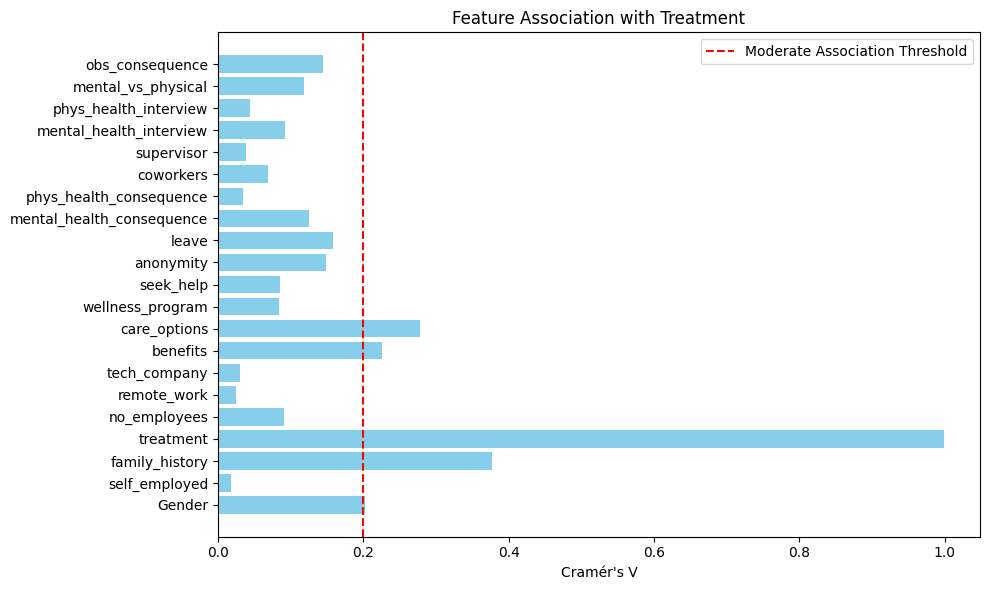

In [35]:
import matplotlib.pyplot as plt

features = [ 'Gender', 'self_employed', 'family_history', 'treatment', 'no_employees',
             'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program',
             'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
             'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview',
             'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

scores = [0.2026, 0.0184, 0.3767, 0.9984, 0.0906,
          0.0242, 0.0306, 0.2250, 0.2781, 0.0844,
          0.0859, 0.1485, 0.1577, 0.1249,
          0.0346, 0.0694, 0.0385, 0.0917,
          0.0440, 0.1179, 0.1447]

plt.figure(figsize=(10,6))
plt.barh(features, scores, color='skyblue')
plt.axvline(0.2, color='red', linestyle='--', label='Moderate Association Threshold')
plt.xlabel("Cramér's V")
plt.title("Feature Association with Treatment")
plt.legend()
plt.tight_layout()
plt.show()


**So we will just retain that particular Columns**

In [41]:
strong_features = [
    'Gender', 'family_history', 'benefits', 'care_options',
    'anonymity', 'leave', 'mental_health_consequence', 
    'mental_vs_physical', 'obs_consequence'
]

selected_features = strong_features + ['treatment']
df_selected = df[selected_features].copy()


In [42]:
df_selected.head()

,Gender,family_history,benefits,care_options,anonymity,leave,mental_health_consequence,mental_vs_physical,obs_consequence,treatment
0,Female,No,Yes,Not sure,Yes,Somewhat easy,No,Yes,No,Yes
1,Male,No,Don't know,No,Don't know,Don't know,Maybe,Don't know,No,No
2,Male,No,No,No,Don't know,Somewhat difficult,No,No,No,No
3,Male,Yes,No,Yes,No,Somewhat difficult,Yes,No,Yes,Yes
4,Male,No,Yes,No,Don't know,Don't know,No,Don't know,No,No


In [43]:
for col in df_selected.columns:
    print(f"{col}:",df[col].unique())

Gender: ['Female' 'Male' 'Other' 'Transgender' 'Non-binary']
family_history: ['No' 'Yes']
benefits: ['Yes' "Don't know" 'No']
care_options: ['Not sure' 'No' 'Yes']
anonymity: ['Yes' "Don't know" 'No']
leave: ['Somewhat easy' "Don't know" 'Somewhat difficult' 'Very difficult'
 'Very easy']
mental_health_consequence: ['No' 'Maybe' 'Yes']
mental_vs_physical: ['Yes' "Don't know" 'No']
obs_consequence: ['No' 'Yes']
treatment: ['Yes' 'No']


In [44]:
df_selected['age_range'] = pd.cut(df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

In [45]:
def encode_mental_health_data(df):
    # Mapping dictionaries
    binary_map = {'No': 0, 'Yes': 1}
    ternary_map = {'No': 0, 'Not sure': 1, "Don't know": 1, 'Yes': 2}
    maybe_map = {'No': 0, 'Maybe': 1, 'Yes': 2}
    leave_map = {
        'Very easy': 0,
        'Somewhat easy': 1,
        "Don't know": 2,
        'Somewhat difficult': 3,
        'Very difficult': 4
    }
    gender_map = {
        'Male': 0,
        'Female': 1,
        'Other': 2,
        'Transgender': 3,
        'Non-binary': 4
    }
    
    # Apply mappings
    df = df.copy()  # avoid modifying original dataframe
    df['treatment'] = df['treatment'].map(binary_map)
    df['family_history'] = df['family_history'].map(binary_map)
    df['obs_consequence'] = df['obs_consequence'].map(binary_map)

    df['benefits'] = df['benefits'].map(ternary_map)
    df['care_options'] = df['care_options'].map(ternary_map)
    df['anonymity'] = df['anonymity'].map(ternary_map)
    df['mental_vs_physical'] = df['mental_vs_physical'].map(ternary_map)

    df['mental_health_consequence'] = df['mental_health_consequence'].map(maybe_map)
    df['leave'] = df['leave'].map(leave_map)

    df['Gender'] = df['Gender'].map(gender_map)
    return df


In [48]:
# Encode it
df_encoded = encode_mental_health_data(df_selected)

In [49]:
def age_bucket(age):
    if age <= 20:
        return "0-20"
    elif age <= 30:
        return "21-30"
    elif age <= 65:
        return "31-65"
    else:
        return "66-100"

df_encoded['age_range'] = df['Age'].map(age_bucket)


In [50]:

df_encoded.head()

,Gender,family_history,benefits,care_options,anonymity,leave,mental_health_consequence,mental_vs_physical,obs_consequence,treatment,age_range
0,1,0,2,1,2,1,0,2,0,1,31-65
1,0,0,1,0,1,2,1,1,0,0,31-65
2,0,0,0,0,1,3,0,0,0,0,31-65
3,0,1,0,2,0,3,2,0,1,1,31-65
4,0,0,2,0,1,2,0,1,0,0,31-65


# **Data Encoding**

In [51]:

labelDict = {}
for feature in df_selected:
    le = preprocessing.LabelEncoder()
    le.fit(df_selected[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    df_selected[feature] = le.transform(df_selected[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)


label_Gender ['Female', 'Male', 'Non-binary', 'Other', 'Transgender']
label_family_history ['No', 'Yes']
label_benefits ["Don't know", 'No', 'Yes']
label_care_options ['No', 'Not sure', 'Yes']
label_anonymity ["Don't know", 'No', 'Yes']
label_leave ["Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', 'Very easy']
label_mental_health_consequence ['Maybe', 'No', 'Yes']
label_mental_vs_physical ["Don't know", 'No', 'Yes']
label_obs_consequence ['No', 'Yes']
label_treatment ['No', 'Yes']
label_age_range ['0-20', '21-30', '31-65']


In [108]:
df_selected.head()

,Gender,family_history,benefits,care_options,anonymity,leave,mental_health_consequence,mental_vs_physical,obs_consequence,treatment,age_range
0,0,0,2,1,2,2,1,2,0,1,2
1,1,0,0,0,0,0,0,0,0,0,2
2,1,0,1,0,0,1,1,1,0,0,2
3,1,1,1,2,1,1,2,1,1,1,2
4,1,0,2,0,0,0,1,0,0,0,2


# **Data Splitting**

In [91]:
X = df_selected.drop('treatment', axis=1)
y = df_selected['treatment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)


In [105]:
results = {}

# **Model Trainings + Evaluation**

In [106]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test,y_pred)

results["Logistic Regression"] = acc

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       121
           1       0.71      0.63      0.67       123

    accuracy                           0.68       244
   macro avg       0.69      0.68      0.68       244
weighted avg       0.69      0.68      0.68       244



In [107]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test,y_pred)

results["Decision Tree"] = acc

              precision    recall  f1-score   support

           0       0.56      0.69      0.62       121
           1       0.60      0.47      0.53       123

    accuracy                           0.58       244
   macro avg       0.58      0.58      0.57       244
weighted avg       0.58      0.58      0.57       244



In [129]:
model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='log2',
    max_depth=None,
    bootstrap=True,class_weight='balanced'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test,y_pred)

results["Random Forest"] = acc

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       121
           1       0.73      0.69      0.71       123

    accuracy                           0.72       244
   macro avg       0.72      0.72      0.72       244
weighted avg       0.72      0.72      0.72       244



In [109]:
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test,y_pred)

results["XGBoost"] = acc

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       121
           1       0.66      0.59      0.63       123

    accuracy                           0.64       244
   macro avg       0.65      0.64      0.64       244
weighted avg       0.65      0.64      0.64       244



In [110]:

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test,y_pred)

results["SVC"] = acc

              precision    recall  f1-score   support

           0       0.66      0.76      0.70       121
           1       0.72      0.61      0.66       123

    accuracy                           0.68       244
   macro avg       0.69      0.69      0.68       244
weighted avg       0.69      0.68      0.68       244



In [111]:
model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test,y_pred)
results["GuassianNB"] = acc

              precision    recall  f1-score   support

           0       0.64      0.74      0.69       121
           1       0.70      0.60      0.65       123

    accuracy                           0.67       244
   macro avg       0.67      0.67      0.67       244
weighted avg       0.67      0.67      0.67       244



In [118]:
model = LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test,y_pred)
results["LGBMClassifier"] = acc

[LightGBM] [Info] Number of positive: 491, number of negative: 484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 975, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503590 -> initscore=0.014359
[LightGBM] [Info] Start training from score 0.014359
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       121
           1       0.67      0.63      0.65       123

    accuracy                           0.66       244
   macro avg       0.66      0.66      0.66       244
weighted avg       0.66      0.66      0.66       244



In [119]:
model = BaggingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test,y_pred)
results["Bagging"] = acc

              precision    recall  f1-score   support

           0       0.60      0.63      0.62       121
           1       0.62      0.59      0.61       123

    accuracy                           0.61       244
   macro avg       0.61      0.61      0.61       244
weighted avg       0.61      0.61      0.61       244



In [96]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
print("F1 Mean:", scores.mean())


F1 Mean: 0.6599544784199403


**RANDOM Search CV**

In [72]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,              # You can reduce this to 20 if it takes too long
    cv=5,                   # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1               # Use all available cores
)
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=5, n_esti

# **Model Performances**

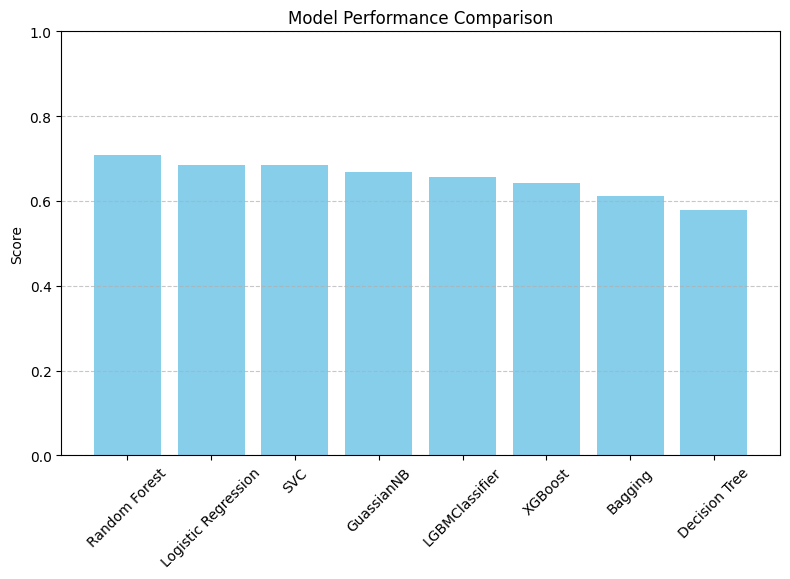

In [125]:
results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

# Convert to two lists
models = list(results.keys())
scores = list(results.values())

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, scores, color='skyblue')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

**Best Performing Model**

In [128]:
best_model = max(results, key=results.get)
best_score = results[best_model]

print("Best Model:", best_model)
print("Score:", best_score)


Best Model: Random Forest
Score: 0.7090163934426229


In [130]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [131]:
!pip freeze > requirements.txt
